## 1. EURUSD-Labels laden

In diesem Abschnitt lade ich die bereits berechneten EURUSD-Labels aus  
`data/processed/fx/eurusd_labels.csv`.

- Die Datei enthält für jeden Tag:
  - `Date`: Datum
  - `Close`, `High`, `Low`, `Open`, `Volume`
  - `lookahead_return`: Rendite über 4 Tage (t → t+4)
  - `label`: Klassifikation (`up`, `down`, `neutral`) mit strenger Monotonie-Bedingung

Da wir die News-Daten erst ab 2020 haben, filtere ich die Labels hier ebenfalls ab 2020.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Optional: etwas schönere Standard-Optik
plt.style.use("seaborn-v0_8")

# EURUSD-Labels laden (inkl. lookahead_return und label)
# Pfad relativ vom Notebook-Ordner (notebooks/) aus
labels = pd.read_csv(
    "../data/processed/fx/eurusd_labels.csv",
    parse_dates=["Date"]
)

# Ab 2020 filtern, weil es ab da News-Features gibt
labels_2020 = labels[labels["Date"] >= "2020-01-01"].copy()

labels_2020.head()


,Date,Close,High,Low,Open,Volume,lookahead_return,label
1301,2020-01-01,1.122083,1.122838,1.115947,1.122083,0,-0.002035,neutral
1302,2020-01-02,1.122083,1.122712,1.116682,1.121894,0,-0.005890,neutral
1303,2020-01-03,1.117144,1.118068,1.112570,1.117081,0,-0.005212,neutral
1304,2020-01-06,1.116196,1.120825,1.115810,1.116246,0,-0.004556,neutral
1305,2020-01-07,1.119799,1.119946,1.113487,1.119583,0,-0.007263,neutral


## 2. Kursverlauf und 4-Tage-Rendite visualisieren

Hier plotte ich zwei Größen gleichzeitig:

1. **EURUSD-Schlusskurs** auf der linken Y-Achse  
2. **4-Tage-Lookahead-Rendite** (`lookahead_return`) auf der rechten Y-Achse

Zusätzlich zeichne ich die Schwellen von **+1 %** und **−1 %** ein.
Diese Schwellen werden aktuell für das Labeling verwendet:

- `up`, wenn Rendite ≥ +1 % und der Kurs 4 Tage in Folge streng steigt
- `down`, wenn Rendite ≤ −1 % und der Kurs 4 Tage in Folge streng fällt
- sonst `neutral`

Die Grafik hilft mir zu verstehen, wann der Kurs wirklich „trendartig“ steigt oder fällt.


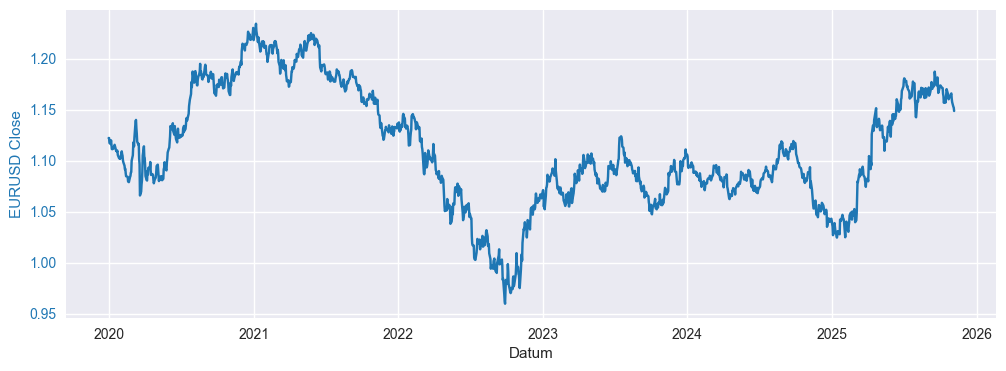

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# 1. Achse: EURUSD-Schlusskurs
ax1.plot(labels_2020["Date"], labels_2020["Close"],
         color="tab:blue", label="Close")
ax1.set_xlabel("Datum")
ax1.set_ylabel("EURUSD Close", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# # 2. Achse: Lookahead-Return über 4 Tage
# ax2 = ax1.twinx()
# ax2.plot(labels_2020["Date"], labels_2020["lookahead_return"],
# color="tab:orange", label="4-Tage-Return")
# ax2.axhline(0.01, color="green", linestyle="--", alpha=0.5, label="+1% Schwelle")
# ax2.axhline(-0.01, color="red", linestyle="--", alpha=0.5, label="-1% Schwelle")
# ax2.set_ylabel("Lookahead-Return (4 Tage)", color="tab:orange")
# ax2.tick_params(axis="y", labelcolor="tab:orange")

# # Gemeinsame Legende
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# plt.title("EURUSD ab 2020 – Kurs & 4-Tage-Return")
# plt.tight_layout()
# plt.show()


## 3. Up/Down-Tage im Kursverlauf hervorheben

In dieser Grafik markiere ich die Tage mit den Labels:

- **grün**: `up`
- **rot**: `down`
- **grau**: `neutral`

Die Kurslinie (hellgrau) zeigt den gesamten Verlauf, die farbigen Punkte markieren die Tage,
an denen nach unserer strengen 4-Tage-Logik ein klares `up` oder `down` erkannt wurde.
So kann ich visuell prüfen, ob das Labeling zu meinem Intuition passt:
„direkte“ Aufwärts- oder Abwärtsbewegungen über 4 Tage ohne Richtungswechsel.


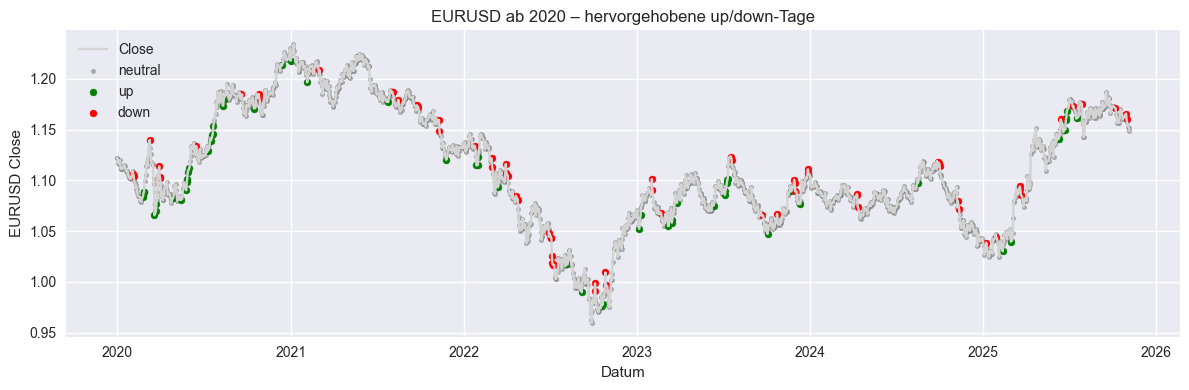

In [12]:
mask_up = labels_2020["label"] == "up"
mask_down = labels_2020["label"] == "down"
mask_neutral = labels_2020["label"] == "neutral"

fig, ax = plt.subplots(figsize=(12, 4))

# Kurslinie
ax.plot(labels_2020["Date"], labels_2020["Close"],
        color="lightgray", label="Close")

# Punkte für neutral / up / down
ax.scatter(labels_2020.loc[mask_neutral, "Date"],
           labels_2020.loc[mask_neutral, "Close"],
           color="gray", s=10, alpha=0.6, label="neutral")

ax.scatter(labels_2020.loc[mask_up, "Date"],
           labels_2020.loc[mask_up, "Close"],
           color="green", s=25, label="up")

ax.scatter(labels_2020.loc[mask_down, "Date"],
           labels_2020.loc[mask_down, "Close"],
           color="red", s=25, label="down")

ax.set_xlabel("Datum")
ax.set_ylabel("EURUSD Close")
ax.set_title("EURUSD ab 2020 – hervorgehobene up/down-Tage")
ax.legend()
plt.tight_layout()
plt.show()
